In [1]:
%reset
import numpy as np
import sys
from scipy.integrate import trapz, simps
from IPython.display import clear_output
import matplotlib.pyplot as plt
%run constants.ipynb

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
sys.path.append('/home/anni/Work/Software/photospheric_code/photospheric_modeling/')

In [3]:
from core import SimulationManager

In [4]:
def calculate_grid_parameters(xmin, xmax, ulim_lastbin):
    D_X = np.log(1/(1-ulim_lastbin/xmax))
    X_I = np.log(xmin)/D_X
    BIN_X = np.log(xmax)/D_X - X_I
    return D_X, int(X_I), int(BIN_X)

In [5]:
def calculate_grid_parameters_DX(xmin, xmax, D_X):
    X_I = np.log(xmin)/D_X
    BIN_X = np.log(xmax)/D_X - X_I
    return int(X_I), int(BIN_X)

In [38]:
xmin = 1.e-9
xmax = 1.e1

D_X = 4.e-2
X_I, BIN_X = calculate_grid_parameters_DX(xmin, xmax, D_X)
print(D_X, X_I, BIN_X)


0.04 -518 575


In [39]:
delta_t = 2.e-11

In [40]:
grid_parameters = {'BIN_X':BIN_X, 'D_X':D_X, 'X_I':X_I, 'type_grid' : 'log'}
solver_settings = {'include_kompaneets': False, 'kompaneets_extended_by': 'none', 'CN_solver': False }

In [41]:
sim = SimulationManager(grid_parameters, delta_t, solver_settings)

In [42]:

initial_array = np.zeros(BIN_X)

In [43]:
T = 10.e3/ k_B_eV

In [44]:
sim.source_parameters['T']=T *k_B_erg/ m_e/c0**2
sim.source_parameters['n_e'] = 6.e20
sim.source_parameters['bprime'] = 1.e4


In [45]:
sim.delta_t = 1.e-2 /(sim.source_parameters['n_e']*sigma_t*c0)

In [46]:
## this is the typical time between scatterings, timestep should be smaller ! 
print(1/(sim.source_parameters['n_e']*sigma_t*c0), sim.delta_t) 

8.356912549957172e-08 8.356912549957172e-10


In [47]:
for k in range(BIN_X):
    x = sim.energygrid[k]
    lgr = x/sim.source_parameters['T']
    #if np.abs(lgr) < 1.e-10: 
    #    print(x)
    #    lgr = 1.e-10
    initial_array[k] = 1/(np.exp(lgr)-1)

In [48]:
sim.initialise_run(initial_array)
modules = [('bremsstrahlung','Bremsstrahlung'), ('doublecompton', 'DoubleCompton'), ('cyclotron', 'Cyclotron')]
#modules = []

sim.reset_modules(modules)

In [49]:
from scipy.interpolate import *

In [50]:
#arr_to_integrate = sim.energygrid**3*sim.photonarray
#E_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *trapz(arr_to_integrate[::10], sim.energygrid[::10])
#print(E_photons)

cspline = CubicSpline(sim.energygrid, sim.energygrid *sim.energygrid *sim.energygrid * sim.photonarray)
E_photons =  8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *cspline.integrate(min(sim.energygrid), max(sim.energygrid))
    

#arr_to_integrate = sim.energygrid**2*sim.photonarray
#N_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *trapz(arr_to_integrate[::10], sim.energygrid[::10])

cspline = CubicSpline(sim.energygrid, sim.energygrid *sim.energygrid * sim.photonarray)
N_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *cspline.integrate(min(sim.energygrid), max(sim.energygrid))
sim.N = N_photons


In [51]:
E_ele = 3/2.* T *k_B_erg*sim.source_parameters['n_e']
print(E_ele)
print(E_ele/E_photons)

14419589706242.924
1.0509918305767864e-05


In [52]:
Etot = E_ele + E_photons

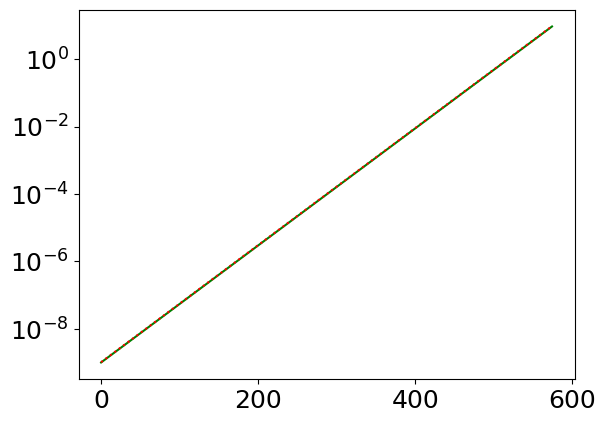

In [53]:
fig = plt.figure()

plt.plot(sim.energygrid, color = 'g')
plt.plot(sim.half_grid, ls = ':', color = 'r')


ax = plt.gca()
ax.set(yscale = 'log')
plt.show()

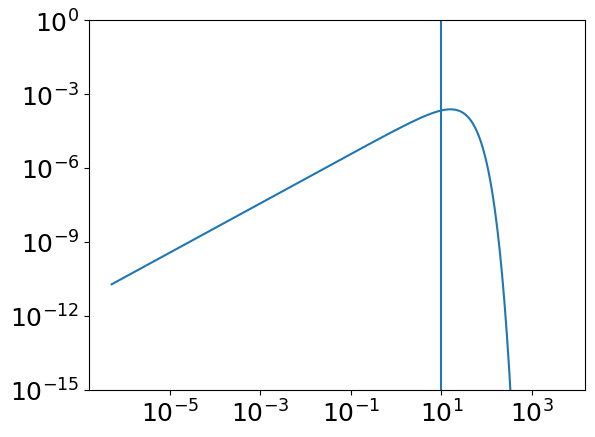

In [54]:
fig = plt.figure()

plt.plot(sim.energygrid*511, initial_array*sim.energygrid**2)
ax = plt.gca()
ax.set(yscale = 'log', xscale='log', ylim = [1.e-15, 1.e0])
ax.axvline(sim.source_parameters['T']*511)

plt.show()

In [55]:
photon_temp_evolution = []
temperature_evolution = []
t_equi_evolution = []

dE_dt_evolution = []

In [56]:
def calculate_t_ele_equilibrium(sim):
    denom = sim.E /(8* np.pi /(c0*h)**3*(m_e*c0**2)**4)
    array_to_integrate = sim.energygrid *sim.energygrid *sim.energygrid*sim.energygrid * sim.photonarray*(sim.photonarray +1)
    cspline = CubicSpline(sim.energygrid, array_to_integrate)
    nom = cspline.integrate(min(sim.energygrid), max(sim.energygrid))
    res = nom/(4*denom)
    return res

In [57]:
def calculate_dE_dt(sim):
    denom = sim.E /(8* np.pi /(c0*h)**3*(m_e*c0**2)**4)
    array_to_integrate = sim.energygrid *sim.energygrid *sim.energygrid*sim.energygrid * sim.photonarray*(sim.photonarray +1)
    cspline = CubicSpline(sim.energygrid, array_to_integrate)
    nom = cspline.integrate(min(sim.energygrid), max(sim.energygrid))
    res = sigma_t * sim.source_parameters['n_e'] *(8*np.pi*h)/(c0**2)*(m_e*c0**2)**4/h**4*(4 *sim.source_parameters['T']  * denom - nom )
    return res

In [58]:
sim.compute_E_total()
sim.compute_N_total()
dE_dt = calculate_dE_dt(sim)
E_ele_curr = E_ele
for j in range(1000):
    clear_output(wait=True)
    T_ele_equi = calculate_t_ele_equilibrium(sim)
    dE_dt = calculate_dE_dt(sim)
    dE_dt_evolution.append(dE_dt)
    Delta_E = dE_dt * sim.delta_t
    if np.abs(Delta_E)/ E_ele_curr > 1.e-4:
        sim.delta_t = 1.e-4*E_ele_curr/np.abs(dE_dt)
    t_equi_evolution.append(T_ele_equi)
    sim.evolve_one_timestep()
    E_ele_curr = Etot - sim.E
    #T_e = E_ele_curr/3. /sim.n_e*2
    #sim.T = T_e/m_e/c0**2
    print(k, sim.source_parameters['T'], T_ele_equi)
    #sim.T = T_ele_equi
    sim.source_parameters['T'] -= dE_dt * sim.delta_t/(3/2 * sim.source_parameters['n_e'] *m_e*c0**2)
    temperature_evolution.append(sim.source_parameters['T'])
    photon_temp_evolution.append(sim.photonarray)
    

boundary between solvers:  573
574 0.019569511836068348 0.01956951183606835


In [59]:
E_ele = (3/2 * np.asarray(temperature_evolution) * m_e*c0**2*sim.source_parameters['n_e'])
Delta_E = np.asarray(dE_dt_evolution)*sim.delta_t

temperatures_from_delta_e = (E_ele + Delta_E)*2/3. /sim.source_parameters['n_e']/m_e/c0**2

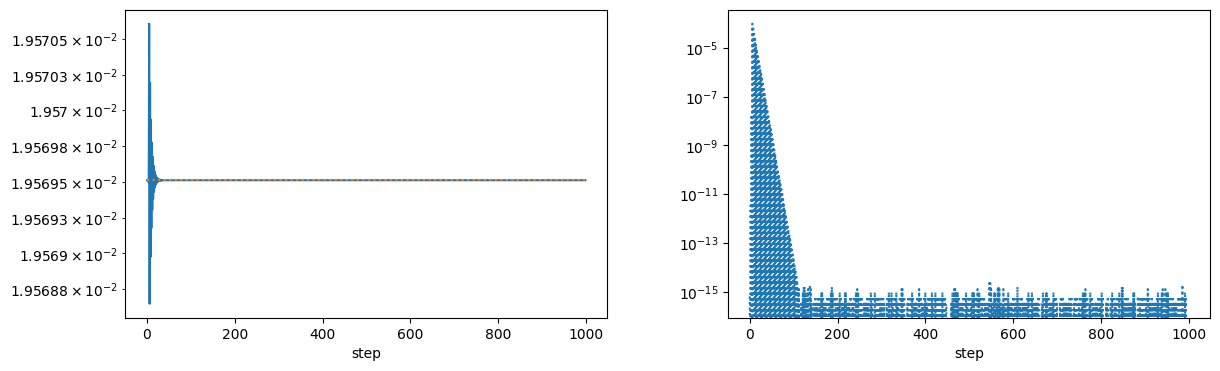

In [28]:
fig, axes = plt.subplots(1, 2, figsize = [14, 4])
plt.subplots_adjust(wspace = 0.25)
ax = axes[0]
ax.plot(temperature_evolution)
ax.plot(t_equi_evolution, ls = ':')
ax.set(yscale= 'log', xlabel = 'step')
ax = axes[1]


ax.plot(Delta_E / E_ele, ls = ':')
ax.set(yscale= 'log', xlabel = 'step')

plt.show()

In [29]:
arr_to_integrate = sim.energygrid**3*sim.photonarray
E_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *trapz(arr_to_integrate, sim.energygrid)
print(E_photons)
E_ele = 3/2 * sim.source_parameters['T'] * k_B_erg*sim.source_parameters['n_e']
print(E_ele)


1.3720020428732165e+18
2431.676425226038


In [30]:
import seaborn as sns

In [31]:
colors = sns.color_palette('BuPu', 8)

/tmp/ipykernel_5350/359795271.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  img = plt.imshow(a, cmap=plt.cm.get_cmap('BuPu', 8))


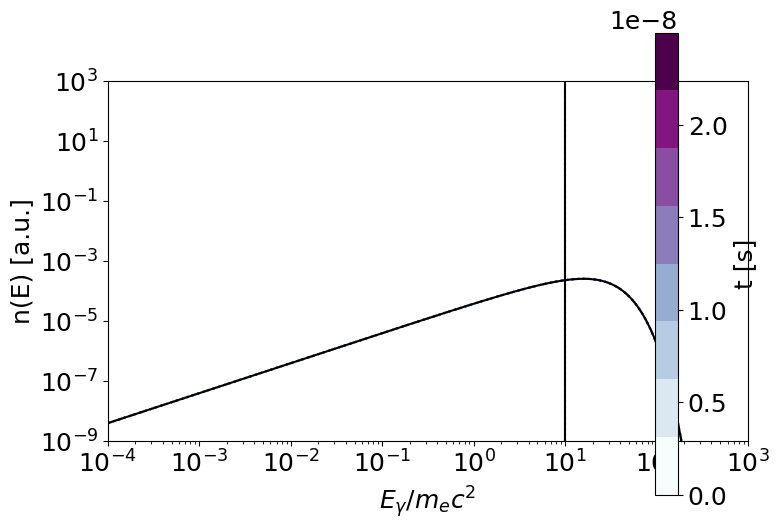

In [32]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize = [8, 6])

a = np.array([[0,sim.time]])
img = plt.imshow(a, cmap=plt.cm.get_cmap('BuPu', 8))
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(label='t [s]')

ax = plt.gca()

for k in range(4):
    ax.plot(sim.energygrid*511, photon_temp_evolution[k]*sim.energygrid**2,
             ls = '--', c = colors[k])
    
ax.plot(sim.energygrid*511, sim.photonarray*sim.energygrid**2, color = 'k')
ax.plot(sim.energygrid*511, initial_array*sim.energygrid**2, ls = ':', 
         color = 'k')
ax.axvline(10., color = 'k', ls = ':')
ax.axvline(sim.source_parameters['T']*511, color = 'k', ls = '-')
ax.set(yscale = 'log', xscale = 'log', 
       xlim = [1.e-4, 1.e3], ylim = [1.e-9, 1.e3],
      xlabel =r'$E_{\gamma}/ m_e c^2$',
      ylabel = 'n(E) [a.u.]')
#plt.savefig('example_comptonisation.png', dpi = 300, bbox_inches = 'tight')
#ax.set(yscale = 'log', xscale = 'log', xlim = [1.e-12, 1.e3], ylim = [1.e-14, 1.e3])
plt.show()

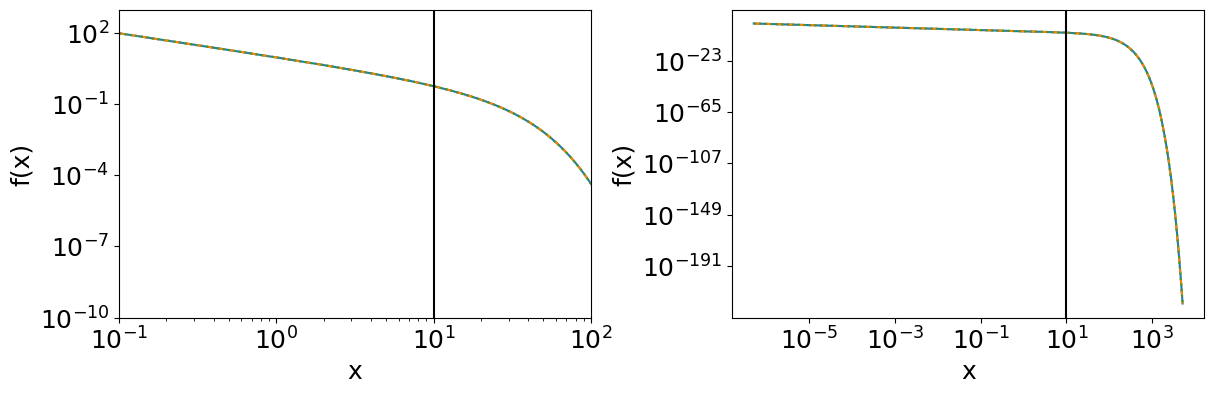

In [33]:
fig, axes = plt.subplots(1,2, figsize = [14, 4])
plt.subplots_adjust(wspace = 0.3)
ax = axes[0]
ax.plot(sim.energygrid*511, sim.photonarray)
ax.plot(sim.energygrid*511, photon_temp_evolution[int(len(photon_temp_evolution)/2)], ls = '--')

ax.plot(sim.energygrid*511, initial_array, ls = ':')
ax.axvline(sim.source_parameters['T'] *511, color = 'k')
ax.set(yscale = 'log', xscale = 'log', 
       xlim = [1.e-1, 1.e2], ylim = [1.e-10, 1.e3], xlabel = 'x', ylabel = 'f(x)')


ax = axes[1]

ax.plot(sim.energygrid*511, sim.photonarray)
ax.plot(sim.energygrid*511, photon_temp_evolution[int(len(photon_temp_evolution)/2)], ls = '--')

ax.plot(sim.energygrid*511, initial_array, ls = ':')
ax.axvline(sim.source_parameters['T']*511, color = 'k')
ax.set(yscale = 'log', xscale = 'log', xlabel = 'x', ylabel = 'f(x)')

#ax.set(yscale = 'log', xscale = 'log', xlim = [1.e-12, 1.e3], ylim = [1.e-14, 1.e3])
plt.show()

In [34]:
brems_cooling = sim.get_coolingrate('Bremsstrahlung')
ad_cooling = sim.get_coolingrate('Adiabatic')
dc_cooling = sim.get_coolingrate('DoubleCompton')
cy_cooling = sim.get_coolingrate('Cyclotron')
ad_aterm = sim.get_aterm('Adiabatic')


In [35]:
brems_inj = sim.get_injectionrate('Bremsstrahlung')
ad_inj = sim.get_injectionrate('Adiabatic')
dc_inj = sim.get_injectionrate('DoubleCompton')
cy_inj = sim.get_injectionrate('Cyclotron')

AttributeError: 'SimulationManager' object has no attribute 'pre_factor_term_kompaneets'

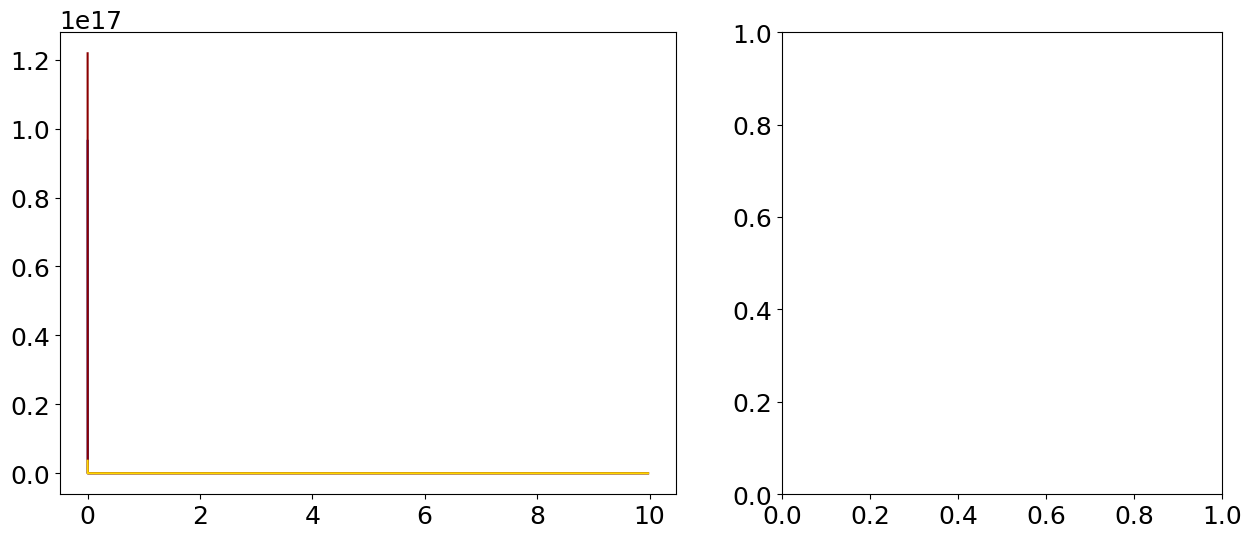

In [36]:
fig, axes = plt.subplots(1, 2, figsize = [15, 6], gridspec_kw={'width_ratios': [1.4, 1]})

ax = axes[0]
ax.plot(sim.energygrid, brems_cooling, ls = '-',  label = r'Bremsstrahlung $\tau^{-1}$', color = 'darkblue')
ax.plot(sim.energygrid, dc_cooling, ls = '-',  label = r'Double Compton $\tau^{-1}$', color = 'darkred')
ax.plot(sim.energygrid, cy_cooling, ls = '-',  label = r'Cyclotron $\tau^{-1}$', color = 'Gold')

ax.plot(sim.half_grid, sim.heating_term_kompaneets*sim.pre_factor_term_kompaneets[:-1]/sim.half_grid, 
        ls = '--', label = r'Kompaneets $a_\mathrm{cool} / x$', color = 'orchid')

ax.legend(ncol = 2, fontsize = 14, framealpha = 1.0, loc = 'lower center')
ax.set(xscale = 'log', yscale = 'log', ylim = [1.e-8, 1.e9])
ax.set(xlabel = 'x', ylabel = r'$t^{-1}_\mathrm{loss}$ [1/s]')
ax.grid(ls = ':')

ax = axes[1]

ax.plot(sim.energygrid, brems_inj, ls = '-', label = 'Bremsstrahlung', color = 'darkblue')
ax.plot(sim.energygrid, dc_inj, ls = '-', label = 'Double Compton', color = 'darkred')
ax.plot(sim.energygrid,cy_inj, ls = '-', label = 'Cyclotron', color = 'Gold')

ax.legend()
ax.set(xscale = 'log', yscale = 'log')
ax.set(ylim = [1.e0, 1.e23])
ax.set(xlabel = 'x', ylabel = r'$\epsilon$(x) 1/cm$^3$s')
ax.grid(ls = ':')
plt.show()

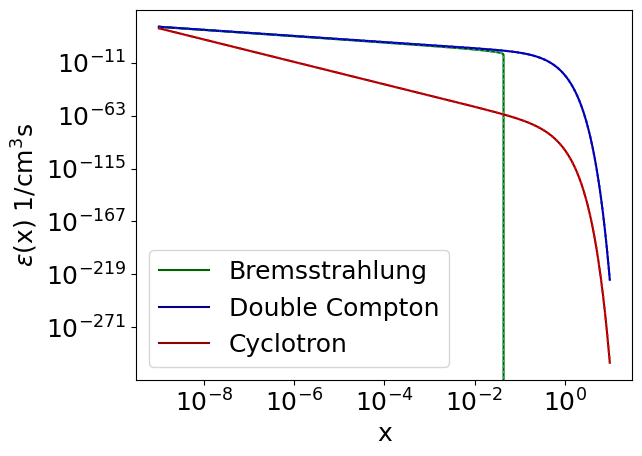

In [37]:
fig, ax = plt.subplots()
ax.plot(sim.energygrid, brems_inj, ls = '-', label = 'Bremsstrahlung', color = 'darkgreen')
ax.plot(sim.energygrid, dc_inj, ls = '-', label = 'Double Compton', color = 'darkblue')
ax.plot(sim.energygrid,cy_inj, ls = '-', label = 'Cyclotron', color = 'darkred')

ax.plot(sim.energygrid, brems_cooling*sim.photonarray, ls = ':', color = 'mediumseagreen')
ax.plot(sim.energygrid, dc_cooling*sim.photonarray, ls = ':', color = 'blue')
ax.plot(sim.energygrid, cy_cooling*sim.photonarray, ls = ':', color = 'red')


ax.legend()
ax.set(xscale = 'log', yscale = 'log')
#ax.set(ylim = [1.e0, 1.e23])
ax.set(xlabel = 'x', ylabel = r'$\epsilon$(x) 1/cm$^3$s')

plt.show()

## Below come some tests for interpolation

In [ ]:
from scipy.interpolate import *

In [ ]:
loggrid = np.log(sim.energygrid)
array_integrate = sim.energygrid *sim.energygrid * sim.photonarray * np.exp(sim.energygrid)
for k in range(len(array_integrate)): 
    if array_integrate[k] < 1.e-220: array_integrate[k] = 1.e-220
log_array_integrate = np.log(array_integrate)

In [ ]:
interpolation = interp1d(loggrid, log_array_integrate,kind='quadratic')

def f_interpolation(xvalue):
    x_log = np.log(xvalue)
    res = np.exp(interpolation(x_log))
    return res

In [ ]:
interpolation2 = interp1d(loggrid, log_array_integrate,kind='cubic')

def f_interpolation2(xvalue):
    x_log = np.log(xvalue)
    res = np.exp(interpolation2(x_log))
    return res

In [ ]:
cspline = CubicSpline(sim.energygrid, sim.energygrid *sim.energygrid * sim.photonarray)

In [ ]:
cspline_integration = cspline.integrate(min(sim.energygrid), max(sim.energygrid))

In [ ]:
print(cspline_integration)

In [ ]:
cspline = CubicSpline(sim.energygrid[::2], sim.energygrid[::2] *sim.energygrid[::2] * sim.photonarray[::2])

In [ ]:
cspline_integration = cspline.integrate(min(sim.energygrid), max(sim.energygrid))

In [ ]:
print(cspline_integration)

In [ ]:
arr_to_integrate = sim.energygrid**2*sim.photonarray
print(trapz(arr_to_integrate[::1], sim.energygrid[::1]))
print(simps(arr_to_integrate[::1], sim.energygrid[::1]))
print(trapz(arr_to_integrate[::10], sim.energygrid[::10]))

In [ ]:
coarse_grid = np.logspace(-3, 2, 100)


In [ ]:
in_values = np.exp(interpolation(np.log(coarse_grid)))

In [ ]:
in2_values = np.exp(interpolation2(np.log(coarse_grid)))

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize = [8, 6])

ax = plt.gca()

    
ax.plot(sim.energygrid*511, sim.photonarray*sim.energygrid**2, color = 'k')
ax.plot(coarse_grid*511, in_values,  color = 'r', marker = 'x', linestyle = 'none', markersize = 10)
ax.plot(coarse_grid*511, in2_values,  color = 'g', marker = 'd', linestyle = 'none')

ax.set(yscale = 'log', xscale = 'log', 
       xlim = [1.e-4, 1.e3], ylim = [1.e-9, 1.e-3],
      xlabel =r'$E_{\gamma}$ [keV]',
      ylabel = 'n(E) [a.u.]')
#plt.savefig('example_comptonisation.png', dpi = 300, bbox_inches = 'tight')
#ax.set(yscale = 'log', xscale = 'log', xlim = [1.e-12, 1.e3], ylim = [1.e-14, 1.e3])
plt.show()

In [ ]:
import numpy as np
from sympy import *
def gauss_laguerre(f, a, b, n):
    """Approximate the definite integral of f from a to b using Gauss-Laguerre quadrature.
    The function f is assumed to be defined on [a,b].
    Parameters:
    f -- a function to be integrated
    a -- lower limit of integration
    b -- upper limit of integration
    n -- number of Gauss-Laguerre quadrature points to use
    Returns:
    The approximate value of the definite integral.
    """
    # Gauss-Laguerre quadrature weights and points
    x, w = np.polynomial.laguerre.laggauss(n)
    print(min(x), max(x))
    # Map x values from [-1, 1] to [a, b]
    #x = (b - a) * x / 2 + (b + a) / 2
    # Evaluate the function at the quadrature points
    fx = f(x)
    # Return the definite integral
    #return (b - a) * np.dot(fx, w) / 2
    return np.dot(fx, w)




In [ ]:
result = gauss_laguerre(f_interpolation, 1/10**(8), 9, 40)
print(result)

In [ ]:
print(np.exp(interpolation(np.log(1.e-100))))